In [1]:
%load_ext autoreload
%autoreload 2

device = "cuda:3"

# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor,CenterCrop

from efficientnet_pytorch import EfficientNet
net = EfficientNet.from_pretrained("efficientnet-b0",num_classes=136)
net = net.to(device)

Loaded pretrained weights for efficientnet-b0


In [2]:
train_transform = transforms.Compose([Rescale(256),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

test_transform = transforms.Compose([Rescale(256),
                                     CenterCrop(224),
                                     Normalize(),
                                     ToTensor()])

In [3]:
train_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=train_transform)


test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test',
                                             transform=test_transform)

print('Number of images: ', len(train_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = train_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())
    
for i in range(4):
    sample = test_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


In [4]:
# load training data in batches
batch_size = 8

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size, 
                          num_workers=0)

In [5]:
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, verbose=True)

In [6]:
def train_net(n_epochs):
    result = pd.DataFrame()
    best_model = net
    prev_loss = 9999999999
    batch_loss = 0
    # prepare the net for training
    net.train()

    for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times
        
        current_lr = optimizer.param_groups[0]['lr']
        print("learning rate:",current_lr)
        running_loss = 0
        
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(tqdm(train_loader)):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)

            # forward pass to get outputs
            output_pts = net(images)
            loss = criterion(output_pts, key_pts)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        train_loss = running_loss/batch_i+1
        test_loss =  test(epoch)
        scheduler.step(test_loss)
        
        result = result.append([[epoch,train_loss,test_loss,current_lr]])
        result.to_csv("landmark_result_eff0_gray.csv", index = False)
        
        print("epoch:", epoch, "train_loss:",train_loss, "test_loss:",test_loss,"learningrate",current_lr)
        if test_loss < prev_loss:
            print("saving")
            best_model = net
            prev_loss = test_loss
            a =str(round(train_loss,4)).replace(".","_")
            b=str(round(test_loss,4)).replace(".","_")
            torch.save(best_model, f"saved_models/eff0_gray_best_model_{epoch}_{a}_{b}")
        else:
            print("model did not improved")
    print('Finished Training')
    return result

def test(epoch):
    net.eval()
    test_loss = 0
    with torch.no_grad():
         for batch_i, data in enumerate(tqdm(test_loader)):
        
        # get sample data: images and ground truth keypoints
            images = data['image']
            key_pts = data['keypoints']
            
            key_pts = key_pts.view(key_pts.size(0), -1)

            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)

            # forward pass to get net output
            output_pts = net(images)
            loss = criterion(output_pts, key_pts)
            test_loss += loss.item()
    test_loss = test_loss/batch_i+1
    return test_loss

In [8]:
if not os.path.isdir("saved_models"):
    os.mkdir("saved_models")

# train your network
n_epochs = 500 # start small, and increase when you've decided on your model structure and hyperparams

result = train_net(n_epochs)
# result.to_csv("landmark_result_eff0_gray.csv", index = False)

learning rate: 0.001



epoch: 0 train_loss: 1.04337692247376 test_loss: 1.0254059563352105 learningrate 0.001
saving
learning rate: 0.001



epoch: 1 train_loss: 1.0177392305496917 test_loss: 1.0034700792505948 learningrate 0.001
saving
learning rate: 0.001



epoch: 2 train_loss: 1.013730183346693 test_loss: 1.012730722820076 learningrate 0.001
model did not improved
learning rate: 0.001



epoch: 3 train_loss: 1.0123014385640596 test_loss: 1.0071732780779712 learningrate 0.001
model did not improved
learning rate: 0.001



epoch: 4 train_loss: 1.017989439402569 test_loss: 1.008827703636295 learningrate 0.001
model did not improved
learning rate: 0.001



epoch: 5 train_loss: 1.0108882753281958 test_loss: 1.0050715300725035 learningrate 0.001
model did not improved
learning rate: 0.001



epoch: 6 train_loss: 1.0074767866247352 test_loss: 1.0041416402503576 learningrate 0.001
model did not improved
learning rate: 0.001



epoch: 7 train_loss: 1.0096599969835585 test_loss: 1.005783241899432 learningrate 0.001
model did not improved
learning rate: 0.001



epoch: 8 train_loss: 1.0116718759613663 test_loss: 1.0073701162764337 learningrate 0.001
model did not improved
learning rate: 0.001



epoch: 9 train_loss: 1.0153631677363861 test_loss: 1.0057848850944235 learningrate 0.001
model did not improved
learning rate: 0.001



epoch: 10 train_loss: 1.005791829234955 test_loss: 1.004012413516951 learningrate 0.001
model did not improved
learning rate: 0.001



epoch: 11 train_loss: 1.007390330911019 test_loss: 1.0036368033361214 learningrate 0.001
model did not improved
learning rate: 0.001



Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
epoch: 12 train_loss: 1.0081171246716554 test_loss: 1.0064326498031733 learningrate 0.001
model did not improved
learning rate: 0.0001



epoch: 13 train_loss: 1.0071165741405652 test_loss: 1.0031202837635647 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 14 train_loss: 1.005017037138815 test_loss: 1.0027330795383023 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 15 train_loss: 1.005752186443176 test_loss: 1.0026043138520133 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 16 train_loss: 1.0038553247216409 test_loss: 1.0025120239151875 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 17 train_loss: 1.0056058663847378 test_loss: 1.0023580987896519 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 18 train_loss: 1.0047304658911782 test_loss: 1.0022943217227294 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 19 train_loss: 1.004225404181246 test_loss: 1.0022088349542173 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 20 train_loss: 1.0027110048325052 test_loss: 1.0021015509870874 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 21 train_loss: 1.0029756522508924 test_loss: 1.0020496223514783 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 22 train_loss: 1.003431778311669 test_loss: 1.0021304084875737 learningrate 0.0001
model did not improved
learning rate: 0.0001



epoch: 23 train_loss: 1.0031533581228966 test_loss: 1.001996036865118 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 24 train_loss: 1.0042216093217442 test_loss: 1.0019814622828562 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 25 train_loss: 1.0041431460421235 test_loss: 1.0019384647651652 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 26 train_loss: 1.002326685013907 test_loss: 1.0018814687755366 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 27 train_loss: 1.0020291576974731 test_loss: 1.0017733390122885 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 28 train_loss: 1.0040665024212945 test_loss: 1.0017474905556203 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 29 train_loss: 1.0043583017710869 test_loss: 1.0017749315362987 learningrate 0.0001
model did not improved
learning rate: 0.0001



epoch: 30 train_loss: 1.0023461170871828 test_loss: 1.001779070918322 learningrate 0.0001
model did not improved
learning rate: 0.0001



epoch: 31 train_loss: 1.0038175018939741 test_loss: 1.0017511104463968 learningrate 0.0001
model did not improved
learning rate: 0.0001



epoch: 32 train_loss: 1.002808972530248 test_loss: 1.001767346688818 learningrate 0.0001
model did not improved
learning rate: 0.0001



epoch: 33 train_loss: 1.0024742097029284 test_loss: 1.0016882068691 learningrate 0.0001
saving
learning rate: 0.0001



epoch: 34 train_loss: 1.0037485670346304 test_loss: 1.0019723441291717 learningrate 0.0001
model did not improved
learning rate: 0.0001



epoch: 35 train_loss: 1.0021522511095908 test_loss: 1.0022300029510613 learningrate 0.0001
model did not improved
learning rate: 0.0001



epoch: 36 train_loss: 1.0037091011967008 test_loss: 1.0018361401101477 learningrate 0.0001
model did not improved
learning rate: 0.0001



epoch: 37 train_loss: 1.0033639240266186 test_loss: 1.0018029325256066 learningrate 0.0001
model did not improved
learning rate: 0.0001



Epoch    39: reducing learning rate of group 0 to 1.0000e-05.
epoch: 38 train_loss: 1.0024288311348453 test_loss: 1.0017626821936574 learningrate 0.0001
model did not improved
learning rate: 1e-05



epoch: 39 train_loss: 1.0019063602847853 test_loss: 1.0016833280982003 learningrate 1e-05
saving
learning rate: 1e-05



epoch: 40 train_loss: 1.0021599438386384 test_loss: 1.0016680229770525 learningrate 1e-05
saving
learning rate: 1e-05



epoch: 41 train_loss: 1.0021655360390098 test_loss: 1.0016563356645445 learningrate 1e-05
saving
learning rate: 1e-05



epoch: 42 train_loss: 1.00210288820273 test_loss: 1.0016439915755957 learningrate 1e-05
saving
learning rate: 1e-05



epoch: 43 train_loss: 1.0022866354241462 test_loss: 1.0016306469818421 learningrate 1e-05
saving
learning rate: 1e-05



epoch: 44 train_loss: 1.0029061659394454 test_loss: 1.0016252786869397 learningrate 1e-05
saving
learning rate: 1e-05



epoch: 45 train_loss: 1.0020810763582833 test_loss: 1.0016246865925496 learningrate 1e-05
saving
learning rate: 1e-05



epoch: 46 train_loss: 1.002150721600359 test_loss: 1.0016231353862775 learningrate 1e-05
saving
learning rate: 1e-05



epoch: 47 train_loss: 1.002187546822016 test_loss: 1.0016160894992936 learningrate 1e-05
saving
learning rate: 1e-05



epoch: 48 train_loss: 1.0017669855186357 test_loss: 1.0016168761721929 learningrate 1e-05
model did not improved
learning rate: 1e-05



epoch: 49 train_loss: 1.0017543225018286 test_loss: 1.001607740741747 learningrate 1e-05
saving
learning rate: 1e-05



epoch: 50 train_loss: 1.0023181739785219 test_loss: 1.0016023480020522 learningrate 1e-05
saving
learning rate: 1e-05



Epoch    52: reducing learning rate of group 0 to 1.0000e-06.
epoch: 51 train_loss: 1.0020662642362166 test_loss: 1.0015990586628807 learningrate 1e-05
saving
learning rate: 1.0000000000000002e-06



epoch: 52 train_loss: 1.001720156509287 test_loss: 1.001593155060012 learningrate 1.0000000000000002e-06
saving
learning rate: 1.0000000000000002e-06



epoch: 53 train_loss: 1.0017387912191258 test_loss: 1.0015925621943704 learningrate 1.0000000000000002e-06
saving
learning rate: 1.0000000000000002e-06



epoch: 54 train_loss: 1.002285701706973 test_loss: 1.001589543119432 learningrate 1.0000000000000002e-06
saving
learning rate: 1.0000000000000002e-06



epoch: 55 train_loss: 1.0019404662049998 test_loss: 1.001590708007522 learningrate 1.0000000000000002e-06
model did not improved
learning rate: 1.0000000000000002e-06



epoch: 56 train_loss: 1.001851840992593 test_loss: 1.0015883303361381 learningrate 1.0000000000000002e-06
saving
learning rate: 1.0000000000000002e-06



epoch: 57 train_loss: 1.0021026157190607 test_loss: 1.0015880529681453 learningrate 1.0000000000000002e-06
saving
learning rate: 1.0000000000000002e-06



epoch: 58 train_loss: 1.0017947465460533 test_loss: 1.0015867606380198 learningrate 1.0000000000000002e-06
saving
learning rate: 1.0000000000000002e-06



epoch: 59 train_loss: 1.001874298219735 test_loss: 1.001586701805839 learningrate 1.0000000000000002e-06
saving
learning rate: 1.0000000000000002e-06



epoch: 60 train_loss: 1.001663541285072 test_loss: 1.0015849747942411 learningrate 1.0000000000000002e-06
saving
learning rate: 1.0000000000000002e-06



epoch: 61 train_loss: 1.0018681537085623 test_loss: 1.0015832966540377 learningrate 1.0000000000000002e-06
saving
learning rate: 1.0000000000000002e-06



Epoch    63: reducing learning rate of group 0 to 1.0000e-07.
epoch: 62 train_loss: 1.001789454771858 test_loss: 1.0015832241842872 learningrate 1.0000000000000002e-06
saving
learning rate: 1.0000000000000002e-07



epoch: 63 train_loss: 1.0018537830557628 test_loss: 1.001582414765532 learningrate 1.0000000000000002e-07
saving
learning rate: 1.0000000000000002e-07



epoch: 64 train_loss: 1.0019944967403986 test_loss: 1.0015822121749807 learningrate 1.0000000000000002e-07
saving
learning rate: 1.0000000000000002e-07



epoch: 65 train_loss: 1.001685276954285 test_loss: 1.0015820798580535 learningrate 1.0000000000000002e-07
saving
learning rate: 1.0000000000000002e-07



epoch: 66 train_loss: 1.0020994232065816 test_loss: 1.0015819371546968 learningrate 1.0000000000000002e-07
saving
learning rate: 1.0000000000000002e-07



epoch: 67 train_loss: 1.0017030262845057 test_loss: 1.0015818865128192 learningrate 1.0000000000000002e-07
saving
learning rate: 1.0000000000000002e-07



epoch: 68 train_loss: 1.0017336425025187 test_loss: 1.0015817642367135 learningrate 1.0000000000000002e-07
saving
learning rate: 1.0000000000000002e-07



epoch: 69 train_loss: 1.0016801180060644 test_loss: 1.0015816335605148 learningrate 1.0000000000000002e-07
saving
learning rate: 1.0000000000000002e-07



epoch: 70 train_loss: 1.0016659122100262 test_loss: 1.0015816337690922 learningrate 1.0000000000000002e-07
model did not improved
learning rate: 1.0000000000000002e-07



epoch: 71 train_loss: 1.0019410545144098 test_loss: 1.0015816547553793 learningrate 1.0000000000000002e-07
model did not improved
learning rate: 1.0000000000000002e-07



epoch: 72 train_loss: 1.0021519680400768 test_loss: 1.00158182744417 learningrate 1.0000000000000002e-07
model did not improved
learning rate: 1.0000000000000002e-07



Epoch    74: reducing learning rate of group 0 to 1.0000e-08.
epoch: 73 train_loss: 1.002011492774963 test_loss: 1.0015817052505251 learningrate 1.0000000000000002e-07
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 74 train_loss: 1.0023766878467641 test_loss: 1.001581705956293 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 75 train_loss: 1.0017850999875346 test_loss: 1.0015816759114387 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 76 train_loss: 1.0022557895367585 test_loss: 1.001581663587179 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 77 train_loss: 1.0019097201665217 test_loss: 1.0015816362368544 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 78 train_loss: 1.001725859090382 test_loss: 1.0015816128288861 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 79 train_loss: 1.001816846724439 test_loss: 1.001581603314359 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 80 train_loss: 1.001752259289518 test_loss: 1.0015815942533663 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 81 train_loss: 1.0017235382985274 test_loss: 1.0015815813179263 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 82 train_loss: 1.0018921797662321 test_loss: 1.0015815768177465 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 83 train_loss: 1.0022169119144597 test_loss: 1.0015815915515607 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 84 train_loss: 1.0024020285092303 test_loss: 1.0015815805393988 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 85 train_loss: 1.0017481049265673 test_loss: 1.001581570707155 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 86 train_loss: 1.0017029503569237 test_loss: 1.0015815723066528 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 87 train_loss: 1.0016632521302975 test_loss: 1.0015815681884608 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 88 train_loss: 1.0017255760475463 test_loss: 1.0015815621469908 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 89 train_loss: 1.0021884622149595 test_loss: 1.0015815280336635 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 90 train_loss: 1.0023556920227916 test_loss: 1.0015815221716668 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 91 train_loss: 1.0025339861267302 test_loss: 1.001581527942714 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 92 train_loss: 1.0018522551647577 test_loss: 1.0015815185846197 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 93 train_loss: 1.0017338382097445 test_loss: 1.0015815059547701 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 94 train_loss: 1.0020422986610222 test_loss: 1.0015814850933868 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 95 train_loss: 1.0024240676920508 test_loss: 1.001581475449105 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 96 train_loss: 1.0018953466895726 test_loss: 1.0015814512783738 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 97 train_loss: 1.001725757466543 test_loss: 1.0015814377123509 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 98 train_loss: 1.002814806144872 test_loss: 1.0015814302411552 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 99 train_loss: 1.001744086959796 test_loss: 1.0015814131220395 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 100 train_loss: 1.0017653837812421 test_loss: 1.001581411926357 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 101 train_loss: 1.0016813064523578 test_loss: 1.0015814063711634 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 102 train_loss: 1.002204448129945 test_loss: 1.0015814116959518 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 103 train_loss: 1.0017093161901964 test_loss: 1.0015814108749812 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 104 train_loss: 1.0018384026787115 test_loss: 1.0015813944155525 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 105 train_loss: 1.0019629600190254 test_loss: 1.0015814007068304 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 106 train_loss: 1.0018982280703819 test_loss: 1.001581416729702 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 107 train_loss: 1.001691736879972 test_loss: 1.00158142081879 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 108 train_loss: 1.0019858018893972 test_loss: 1.0015814211352942 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 109 train_loss: 1.001673414917874 test_loss: 1.001581421434821 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 110 train_loss: 1.0016799687760392 test_loss: 1.0015814152817863 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 111 train_loss: 1.0017254388815975 test_loss: 1.0015814221187611 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 112 train_loss: 1.0016755351715363 test_loss: 1.0015814103414111 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 113 train_loss: 1.0025681964421151 test_loss: 1.0015814145444892 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 114 train_loss: 1.0018189260063755 test_loss: 1.0015813946932515 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 115 train_loss: 1.0025552498615677 test_loss: 1.0015813978752703 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 116 train_loss: 1.002426984644747 test_loss: 1.001581401641791 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 117 train_loss: 1.0019421188431066 test_loss: 1.001581401485358 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 118 train_loss: 1.00197677408303 test_loss: 1.0015813996421155 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 119 train_loss: 1.0023283344123262 test_loss: 1.0015813976303132 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 120 train_loss: 1.0019731357918957 test_loss: 1.0015813982984885 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 121 train_loss: 1.0019257477117074 test_loss: 1.0015813934235969 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 122 train_loss: 1.0028889235261347 test_loss: 1.001581383876328 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 123 train_loss: 1.001724275346162 test_loss: 1.0015813810629577 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 124 train_loss: 1.0028143298080034 test_loss: 1.0015813989120943 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 125 train_loss: 1.0018491553025712 test_loss: 1.001581409710828 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 126 train_loss: 1.0021342677906364 test_loss: 1.0015814144159474 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 127 train_loss: 1.002142187708631 test_loss: 1.001581386003333 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 128 train_loss: 1.001861901038528 test_loss: 1.0015813796041282 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 129 train_loss: 1.001871768669608 test_loss: 1.0015813900802943 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 130 train_loss: 1.0016880075617574 test_loss: 1.0015813887730474 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 131 train_loss: 1.0018792814809314 test_loss: 1.0015813829195395 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 132 train_loss: 1.0017626169651015 test_loss: 1.001581369939231 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 133 train_loss: 1.0019811524190894 test_loss: 1.001581348675245 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 134 train_loss: 1.0019848047044502 test_loss: 1.0015813317586435 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 135 train_loss: 1.0033239102868483 test_loss: 1.0015813377867744 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 136 train_loss: 1.0016354327033494 test_loss: 1.0015813142005452 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 137 train_loss: 1.0019588323855175 test_loss: 1.001581303335115 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 138 train_loss: 1.0017653040099335 test_loss: 1.001581299056852 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 139 train_loss: 1.001663299196446 test_loss: 1.0015812993042346 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 140 train_loss: 1.002018645092499 test_loss: 1.001581311764312 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 141 train_loss: 1.0016814755136794 test_loss: 1.0015812995989108 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 142 train_loss: 1.0017090546602117 test_loss: 1.0015812803879574 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 143 train_loss: 1.0018425919420055 test_loss: 1.0015812818188958 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 144 train_loss: 1.0018007719708193 test_loss: 1.0015812795536476 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 145 train_loss: 1.0017528994665352 test_loss: 1.001581260364522 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 146 train_loss: 1.0029844946960413 test_loss: 1.0015812644196558 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 147 train_loss: 1.00184381940899 test_loss: 1.0015812572140323 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 148 train_loss: 1.0019244326005585 test_loss: 1.0015812489376306 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 149 train_loss: 1.0017769460591135 test_loss: 1.0015812501745434 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 150 train_loss: 1.0021133018007848 test_loss: 1.001581242641502 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 151 train_loss: 1.0019089349769745 test_loss: 1.0015812325752147 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 152 train_loss: 1.0016994842595455 test_loss: 1.0015812319725228 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 153 train_loss: 1.0017354658341868 test_loss: 1.0015812358966893 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 154 train_loss: 1.0023877127719902 test_loss: 1.0015812465717318 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 155 train_loss: 1.0019393511654386 test_loss: 1.001581253050972 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 156 train_loss: 1.0016755699103266 test_loss: 1.0015812521366267 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 157 train_loss: 1.0019538292111032 test_loss: 1.0015812507881492 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 158 train_loss: 1.0018064013041752 test_loss: 1.001581257525686 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 159 train_loss: 1.00188712473755 test_loss: 1.0015812511167799 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 160 train_loss: 1.001763906618618 test_loss: 1.0015812355741218 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 161 train_loss: 1.002547817264443 test_loss: 1.0015812234766297 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 162 train_loss: 1.002140084021381 test_loss: 1.001581228170835 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 163 train_loss: 1.0016720812805202 test_loss: 1.0015812301717233 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 164 train_loss: 1.001684791335046 test_loss: 1.0015812405411755 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 165 train_loss: 1.001792238080304 test_loss: 1.001581237782375 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 166 train_loss: 1.002512191405576 test_loss: 1.0015812293083097 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 167 train_loss: 1.0020865953770732 test_loss: 1.0015812218322633 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 168 train_loss: 1.0021928404228808 test_loss: 1.0015812204692338 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 169 train_loss: 1.0016788436495754 test_loss: 1.001581210407797 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 170 train_loss: 1.0017169155645307 test_loss: 1.0015812107303645 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 171 train_loss: 1.002087193389377 test_loss: 1.0015812131556838 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 172 train_loss: 1.001658284298847 test_loss: 1.0015812024309223 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 173 train_loss: 1.001782317071182 test_loss: 1.0015812050163124 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 174 train_loss: 1.001795795171347 test_loss: 1.0015812026237352 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 175 train_loss: 1.0020271317536955 test_loss: 1.001581195940768 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 176 train_loss: 1.0019686487387474 test_loss: 1.001581194975491 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 177 train_loss: 1.0017750772548661 test_loss: 1.0015811818496634 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 178 train_loss: 1.0023127140968293 test_loss: 1.0015811764266498 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 179 train_loss: 1.0018081166022899 test_loss: 1.0015811811936146 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 180 train_loss: 1.0017768609181479 test_loss: 1.0015811731633828 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 181 train_loss: 1.0019491774477904 test_loss: 1.001581183269688 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 182 train_loss: 1.001903942173764 test_loss: 1.0015811621851753 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 183 train_loss: 1.0020909552986268 test_loss: 1.001581165442379 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 184 train_loss: 1.0018079591342637 test_loss: 1.0015811556161982 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 185 train_loss: 1.0023192628529312 test_loss: 1.001581160266748 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 186 train_loss: 1.0022785192138852 test_loss: 1.0015811689421146 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 187 train_loss: 1.0019317751178245 test_loss: 1.0015811492994544 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 188 train_loss: 1.0016944501027563 test_loss: 1.0015811458009314 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 189 train_loss: 1.0018998031182154 test_loss: 1.0015811524729845 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 190 train_loss: 1.0018197038170238 test_loss: 1.0015811474525738 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 191 train_loss: 1.0016651594104824 test_loss: 1.001581132015417 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 192 train_loss: 1.0024265914956534 test_loss: 1.0015811332098867 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 193 train_loss: 1.0016616474187887 test_loss: 1.0015811346153594 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 194 train_loss: 1.0016788630777296 test_loss: 1.001581128165223 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 195 train_loss: 1.0019127130544803 test_loss: 1.001581106875771 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 196 train_loss: 1.0017205704588614 test_loss: 1.0015811026363128 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 197 train_loss: 1.001925120009724 test_loss: 1.0015810971938965 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 198 train_loss: 1.0022479865451546 test_loss: 1.0015810990043974 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 199 train_loss: 1.00171934313012 test_loss: 1.00158109547192 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 200 train_loss: 1.0017181023959656 test_loss: 1.0015811051562196 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 201 train_loss: 1.0020832206429515 test_loss: 1.0015810929410993 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 202 train_loss: 1.0020856364275528 test_loss: 1.0015811003650015 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 203 train_loss: 1.0016954126455218 test_loss: 1.0015810890157202 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 204 train_loss: 1.0018883415885083 test_loss: 1.0015811017947271 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 205 train_loss: 1.0016826566687895 test_loss: 1.0015810968749672 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 206 train_loss: 1.0027989627555212 test_loss: 1.001581076066941 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 207 train_loss: 1.002082816244823 test_loss: 1.001581074243101 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 208 train_loss: 1.001694509114141 test_loss: 1.0015810678730002 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 209 train_loss: 1.0018410692215116 test_loss: 1.0015810525425575 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 210 train_loss: 1.0019635988766689 test_loss: 1.001581055294082 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 211 train_loss: 1.0016726178958681 test_loss: 1.0015810376183556 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 212 train_loss: 1.0018541423804115 test_loss: 1.0015810152144695 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 213 train_loss: 1.0019709296304629 test_loss: 1.0015810296208656 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 214 train_loss: 1.0019568942365435 test_loss: 1.0015810145171902 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 215 train_loss: 1.001690239165058 test_loss: 1.0015810084999732 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 216 train_loss: 1.0016718064976482 test_loss: 1.0015809979316448 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 217 train_loss: 1.0018068621700675 test_loss: 1.0015809973665455 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 218 train_loss: 1.0018214306195052 test_loss: 1.0015809806645848 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 219 train_loss: 1.0017188920758566 test_loss: 1.0015809842164647 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 220 train_loss: 1.0017646961096034 test_loss: 1.001580975427108 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 221 train_loss: 1.0017639293088265 test_loss: 1.0015809885092797 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 222 train_loss: 1.0016855894757977 test_loss: 1.0015809929415507 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 223 train_loss: 1.001829517735772 test_loss: 1.0015809859881604 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 224 train_loss: 1.0018148822420228 test_loss: 1.001580986919483 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 225 train_loss: 1.001720577639558 test_loss: 1.0015809907260216 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 226 train_loss: 1.001909701761448 test_loss: 1.001580981472216 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 227 train_loss: 1.0016908023721447 test_loss: 1.0015809815486136 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 228 train_loss: 1.001883795003744 test_loss: 1.0015810017127176 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 229 train_loss: 1.0020746809006797 test_loss: 1.0015809889834297 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 230 train_loss: 1.0017240196035277 test_loss: 1.0015810044120979 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 231 train_loss: 1.0017583763498503 test_loss: 1.0015809992340412 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 232 train_loss: 1.0021730666388369 test_loss: 1.0015809673604963 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 233 train_loss: 1.0023075002535295 test_loss: 1.0015809620769385 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 234 train_loss: 1.0017148706171644 test_loss: 1.001580928844002 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 235 train_loss: 1.0018131736702613 test_loss: 1.0015809138809952 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 236 train_loss: 1.00165099272595 test_loss: 1.0015809180961999 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 237 train_loss: 1.001624098296344 test_loss: 1.0015809168871783 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 238 train_loss: 1.0019066761485225 test_loss: 1.0015809156745188 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 239 train_loss: 1.0018255536515088 test_loss: 1.0015809189911427 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 240 train_loss: 1.0016787867382475 test_loss: 1.0015809069033519 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 241 train_loss: 1.001933892252122 test_loss: 1.00158088502576 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 242 train_loss: 1.0021200246409097 test_loss: 1.0015808680097205 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 243 train_loss: 1.001905701217496 test_loss: 1.0015808901637986 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 244 train_loss: 1.0020221329475505 test_loss: 1.0015809011226036 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 245 train_loss: 1.001668259999995 test_loss: 1.0015808966624415 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 246 train_loss: 1.0016170517309446 test_loss: 1.0015808980958052 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 247 train_loss: 1.0021589520176888 test_loss: 1.0015808969753077 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 248 train_loss: 1.0017420012853917 test_loss: 1.001580906210923 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 249 train_loss: 1.0017452373956783 test_loss: 1.001580907501193 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 250 train_loss: 1.001877461389894 test_loss: 1.0015809089381946 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 251 train_loss: 1.0016571961911083 test_loss: 1.0015809046769089 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 252 train_loss: 1.0017205281334032 test_loss: 1.0015809035212442 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 253 train_loss: 1.0018444947707865 test_loss: 1.0015809016949788 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 254 train_loss: 1.0022961723188928 test_loss: 1.0015808975877007 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 255 train_loss: 1.001785193937394 test_loss: 1.0015808951405536 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 256 train_loss: 1.00182101337756 test_loss: 1.001580893782375 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 257 train_loss: 1.001706963370924 test_loss: 1.001580881769769 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 258 train_loss: 1.0020753917789855 test_loss: 1.0015808818461664 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 259 train_loss: 1.0016584662119352 test_loss: 1.0015808780117368 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 260 train_loss: 1.0021819879976748 test_loss: 1.0015808584842791 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 261 train_loss: 1.0023591363347402 test_loss: 1.0015808589099227 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 262 train_loss: 1.0016924382162633 test_loss: 1.0015808533098607 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 263 train_loss: 1.0017062832689758 test_loss: 1.0015808512907824 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 264 train_loss: 1.0024019622028897 test_loss: 1.0015808427306183 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 265 train_loss: 1.0023518211427371 test_loss: 1.0015808459187003 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 266 train_loss: 1.001851197069266 test_loss: 1.001580857031513 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 267 train_loss: 1.0016710281762007 test_loss: 1.0015808447775878 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 268 train_loss: 1.0017207505076873 test_loss: 1.001580845265077 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 269 train_loss: 1.0022265280951816 test_loss: 1.0015808422031114 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 270 train_loss: 1.0016746387960598 test_loss: 1.0015808350265918 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 271 train_loss: 1.0018141035955825 test_loss: 1.001580833682965 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 272 train_loss: 1.0018341569351226 test_loss: 1.0015808366600443 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 273 train_loss: 1.0016543954324906 test_loss: 1.0015808321768418 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 274 train_loss: 1.001686419049764 test_loss: 1.0015808492814056 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 275 train_loss: 1.0016833358305222 test_loss: 1.0015808341510517 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 276 train_loss: 1.0017786542755656 test_loss: 1.0015808300001179 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 277 train_loss: 1.0016988520297605 test_loss: 1.0015808167360472 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 278 train_loss: 1.001711316344477 test_loss: 1.0015808124565713 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 279 train_loss: 1.0019110347690272 test_loss: 1.0015808233777836 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 280 train_loss: 1.0020650041719987 test_loss: 1.001580836782523 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 281 train_loss: 1.0021779257184351 test_loss: 1.0015808303251106 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 282 train_loss: 1.0017339054711218 test_loss: 1.0015808214496549 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 283 train_loss: 1.0017928180583382 test_loss: 1.0015808122746723 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 284 train_loss: 1.0023458718686824 test_loss: 1.001580797972565 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 285 train_loss: 1.0018579260691627 test_loss: 1.0015807979349727 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 286 train_loss: 1.0029728108311247 test_loss: 1.0015807803647476 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 287 train_loss: 1.0017742560207639 test_loss: 1.001580797994393 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 288 train_loss: 1.001692797963861 test_loss: 1.001580788279777 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 289 train_loss: 1.0017911733207088 test_loss: 1.00158077935824 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 290 train_loss: 1.0019325881922096 test_loss: 1.0015807663245748 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 291 train_loss: 1.001872479878835 test_loss: 1.0015807702948223 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 292 train_loss: 1.0018619606813042 test_loss: 1.0015807688869245 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 293 train_loss: 1.001960594567343 test_loss: 1.0015807789604878 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 294 train_loss: 1.0021405265784038 test_loss: 1.00158077641269 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 295 train_loss: 1.0018628868768886 test_loss: 1.0015807677724904 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 296 train_loss: 1.0017036436275466 test_loss: 1.0015807793776428 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 297 train_loss: 1.0028410885098749 test_loss: 1.0015807599920663 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 298 train_loss: 1.0018383384803773 test_loss: 1.0015807622476132 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 299 train_loss: 1.0017451214476347 test_loss: 1.0015807611489436 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 300 train_loss: 1.0019221348023468 test_loss: 1.0015807493970594 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 301 train_loss: 1.0017472747186493 test_loss: 1.0015807508461876 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 302 train_loss: 1.0016725867346934 test_loss: 1.00158074321007 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 303 train_loss: 1.001863876691695 test_loss: 1.0015807443633093 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 304 train_loss: 1.0017557310238772 test_loss: 1.001580740306963 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 305 train_loss: 1.0018272974994034 test_loss: 1.0015807374754029 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 306 train_loss: 1.0017079001621891 test_loss: 1.0015807315624745 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 307 train_loss: 1.0018302454754358 test_loss: 1.0015807221607247 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 308 train_loss: 1.0016668919636653 test_loss: 1.0015807234012755 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 309 train_loss: 1.002005880017586 test_loss: 1.001580701415757 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 310 train_loss: 1.0021945499985898 test_loss: 1.0015806983416649 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 311 train_loss: 1.002106170380473 test_loss: 1.0015806905406255 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 312 train_loss: 1.0022283107128815 test_loss: 1.0015806942537893 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 313 train_loss: 1.0017923775694388 test_loss: 1.0015806938584622 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 314 train_loss: 1.0016757312433684 test_loss: 1.0015806806162193 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 315 train_loss: 1.001786093580584 test_loss: 1.0015806961879814 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 316 train_loss: 1.0023413846286497 test_loss: 1.0015806760372168 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 317 train_loss: 1.0026354262866974 test_loss: 1.001580682630447 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 318 train_loss: 1.001930410122171 test_loss: 1.00158067169347 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 319 train_loss: 1.001629199911905 test_loss: 1.001580649313837 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 320 train_loss: 1.0018131831396506 test_loss: 1.0015806646370038 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 321 train_loss: 1.0019260960650205 test_loss: 1.0015806479120026 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 322 train_loss: 1.0017179221001613 test_loss: 1.0015806372697018 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 323 train_loss: 1.001967532205459 test_loss: 1.0015806290587836 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 324 train_loss: 1.0025948961829945 test_loss: 1.0015806310305682 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 325 train_loss: 1.0016805530842114 test_loss: 1.0015806287750213 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 326 train_loss: 1.0016736932139556 test_loss: 1.001580618263688 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 327 train_loss: 1.0018784711150888 test_loss: 1.0015806011469977 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 328 train_loss: 1.002045198751013 test_loss: 1.0015805980462271 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 329 train_loss: 1.0016573420170634 test_loss: 1.0015806039288389 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 330 train_loss: 1.00184283444334 test_loss: 1.0015805991946156 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 331 train_loss: 1.0017368400143891 test_loss: 1.0015805971221805 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 332 train_loss: 1.0017532053574945 test_loss: 1.001580598081394 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 333 train_loss: 1.0019892940586874 test_loss: 1.0015806110871683 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 334 train_loss: 1.001788817423841 test_loss: 1.0015806131317124 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 335 train_loss: 1.0016987276953673 test_loss: 1.001580606506953 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 336 train_loss: 1.001755818742418 test_loss: 1.001580584544475 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 337 train_loss: 1.0016761928311975 test_loss: 1.0015805813115246 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 338 train_loss: 1.002762990127074 test_loss: 1.0015805867697054 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 339 train_loss: 1.0016244414662112 test_loss: 1.001580576692504 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 340 train_loss: 1.0018631535302254 test_loss: 1.001580572664049 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 341 train_loss: 1.0022758276645618 test_loss: 1.0015805843953178 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 342 train_loss: 1.0018422824296405 test_loss: 1.001580600138065 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 343 train_loss: 1.001685722327777 test_loss: 1.0015805895369947 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 344 train_loss: 1.0021583752735481 test_loss: 1.001580585121701 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 345 train_loss: 1.0016340786783582 test_loss: 1.0015805825908803 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 346 train_loss: 1.0017517339012423 test_loss: 1.0015805753597913 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 347 train_loss: 1.0018974451472955 test_loss: 1.0015805702605576 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 348 train_loss: 1.001881540367052 test_loss: 1.0015805606672075 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 349 train_loss: 1.0018343133974499 test_loss: 1.0015805664806976 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 350 train_loss: 1.0017602702576336 test_loss: 1.0015805676036205 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 351 train_loss: 1.0017076845394546 test_loss: 1.0015805646604956 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 352 train_loss: 1.002366310884773 test_loss: 1.0015805578162447 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 353 train_loss: 1.0017103100816949 test_loss: 1.00158056879809 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 354 train_loss: 1.0021303632506546 test_loss: 1.0015805552308545 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 355 train_loss: 1.0016926418921448 test_loss: 1.0015805703636336 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 356 train_loss: 1.0019498335431207 test_loss: 1.0015805597383103 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 357 train_loss: 1.0016897396769007 test_loss: 1.0015805613887399 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 358 train_loss: 1.0017666076927088 test_loss: 1.001580561317193 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 359 train_loss: 1.0017102881158482 test_loss: 1.0015805553448445 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 360 train_loss: 1.0016891409875286 test_loss: 1.001580553280898 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 361 train_loss: 1.0017088077670282 test_loss: 1.0015805497447825 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 362 train_loss: 1.0021891619051329 test_loss: 1.001580530533829 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 363 train_loss: 1.0018625828173147 test_loss: 1.0015805211017625 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 364 train_loss: 1.001790152124832 test_loss: 1.0015805341378534 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 365 train_loss: 1.0016976496326269 test_loss: 1.001580524174642 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 366 train_loss: 1.0021459273954894 test_loss: 1.0015805197338825 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 367 train_loss: 1.0016976988715922 test_loss: 1.0015805243541156 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 368 train_loss: 1.0017293910792364 test_loss: 1.0015805200807033 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 369 train_loss: 1.001741742976635 test_loss: 1.00158050280758 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 370 train_loss: 1.0016685965271823 test_loss: 1.0015805060174898 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 371 train_loss: 1.0016928981608038 test_loss: 1.0015805015743051 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 372 train_loss: 1.0020913146038732 test_loss: 1.00158050280758 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 373 train_loss: 1.0020738589360176 test_loss: 1.0015805067159818 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 374 train_loss: 1.0017501823838555 test_loss: 1.001580509643342 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 375 train_loss: 1.0017312623946324 test_loss: 1.0015804984153267 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 376 train_loss: 1.0017994233952507 test_loss: 1.0015804917602509 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 377 train_loss: 1.0017275687546148 test_loss: 1.001580495525559 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 378 train_loss: 1.0017032222792666 test_loss: 1.0015804799101413 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 379 train_loss: 1.001637526051194 test_loss: 1.0015804835372062 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 380 train_loss: 1.00289698569193 test_loss: 1.001580482724724 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 381 train_loss: 1.001699472158011 test_loss: 1.0015804780596227 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 382 train_loss: 1.0016644895309852 test_loss: 1.0015804738238028 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 383 train_loss: 1.0016318019259887 test_loss: 1.0015804659730445 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 384 train_loss: 1.0018906550199231 test_loss: 1.001580445333578 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 385 train_loss: 1.0017003396798694 test_loss: 1.0015804503394368 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 386 train_loss: 1.0025424857187857 test_loss: 1.0015804390689784 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 387 train_loss: 1.0017805851325479 test_loss: 1.0015804273777273 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 388 train_loss: 1.0018067656841325 test_loss: 1.0015804282569054 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 389 train_loss: 1.0020075846914551 test_loss: 1.0015804298200237 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 390 train_loss: 1.0016768170183543 test_loss: 1.0015804407181956 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 391 train_loss: 1.0019349458122666 test_loss: 1.0015804172896121 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 392 train_loss: 1.0022504143895208 test_loss: 1.0015804076477555 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 393 train_loss: 1.0024619633466634 test_loss: 1.001580411468846 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 394 train_loss: 1.0019273564418352 test_loss: 1.0015804149770702 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 395 train_loss: 1.0021933968260042 test_loss: 1.0015804136625472 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 396 train_loss: 1.0019017034053965 test_loss: 1.0015804217133943 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 397 train_loss: 1.0018116259207428 test_loss: 1.0015804067940433 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 398 train_loss: 1.0017642807091491 test_loss: 1.0015804067443241 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 399 train_loss: 1.002295971318273 test_loss: 1.0015804022550583 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 400 train_loss: 1.0016927760741425 test_loss: 1.0015803917849553 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 401 train_loss: 1.0018170068371413 test_loss: 1.0015803774173644 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 402 train_loss: 1.0017296265573856 test_loss: 1.001580372855339 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 403 train_loss: 1.0017532952753956 test_loss: 1.0015803688426483 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 404 train_loss: 1.0019418329889218 test_loss: 1.0015803506333516 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 405 train_loss: 1.0016446755862152 test_loss: 1.0015803625901754 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 406 train_loss: 1.0017064222249448 test_loss: 1.0015803560005831 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 407 train_loss: 1.0016506821499476 test_loss: 1.0015803575697646 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 408 train_loss: 1.0027014231007476 test_loss: 1.0015803532878635 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 409 train_loss: 1.0016882383346524 test_loss: 1.001580354241014 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 410 train_loss: 1.0017111490342359 test_loss: 1.0015803439928277 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 411 train_loss: 1.0026221125359978 test_loss: 1.0015803385152442 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 412 train_loss: 1.0017321628221436 test_loss: 1.0015803475495584 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 413 train_loss: 1.001627897605094 test_loss: 1.001580345306138 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 414 train_loss: 1.0021864742256756 test_loss: 1.0015803350615897 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 415 train_loss: 1.0022983830546124 test_loss: 1.0015803286393445 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 416 train_loss: 1.0016967345463517 test_loss: 1.001580334501341 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 417 train_loss: 1.0018792943252872 test_loss: 1.001580335598798 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 418 train_loss: 1.0018935101582396 test_loss: 1.0015803322918753 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 419 train_loss: 1.0020577192793738 test_loss: 1.0015803264116887 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 420 train_loss: 1.0018048979415013 test_loss: 1.0015803220303496 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 421 train_loss: 1.0016823273679754 test_loss: 1.0015803267039398 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 422 train_loss: 1.0017519627336124 test_loss: 1.001580336678065 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 423 train_loss: 1.001727544332459 test_loss: 1.0015803319547558 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 424 train_loss: 1.0017776700094854 test_loss: 1.0015803369315108 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 425 train_loss: 1.0019442309010762 test_loss: 1.0015803406373986 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 426 train_loss: 1.0017797694297903 test_loss: 1.0015803376118129 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 427 train_loss: 1.0019223693113115 test_loss: 1.001580322915591 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 428 train_loss: 1.0018303375095625 test_loss: 1.0015803109078358 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 429 train_loss: 1.001860016414597 test_loss: 1.0015803213609615 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 430 train_loss: 1.0020797174138014 test_loss: 1.0015803149387164 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 431 train_loss: 1.0018515415085185 test_loss: 1.0015803111467296 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 432 train_loss: 1.0017115791000564 test_loss: 1.0015803121981055 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 433 train_loss: 1.0018561299883812 test_loss: 1.0015803118609863 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 434 train_loss: 1.002079804962435 test_loss: 1.0015803102651262 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 435 train_loss: 1.0025228640787882 test_loss: 1.0015803248425073 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 436 train_loss: 1.0017174757584277 test_loss: 1.001580330090898 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 437 train_loss: 1.0019811023374603 test_loss: 1.0015803305165416 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 438 train_loss: 1.0019188380032977 test_loss: 1.0015803291280463 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 439 train_loss: 1.001822064711127 test_loss: 1.0015803298908093 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 440 train_loss: 1.001708440374555 test_loss: 1.0015803322057764 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 441 train_loss: 1.0022285819345766 test_loss: 1.0015803248534212 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 442 train_loss: 1.0020918537943713 test_loss: 1.0015803203787073 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 443 train_loss: 1.0016462241336639 test_loss: 1.001580318701599 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 444 train_loss: 1.0016315297177276 test_loss: 1.0015803222401398 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 445 train_loss: 1.0026666363757815 test_loss: 1.001580311227978 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 446 train_loss: 1.0020559946067267 test_loss: 1.0015803113359045 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 447 train_loss: 1.0018483318851428 test_loss: 1.0015803121350473 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 448 train_loss: 1.0017004259390416 test_loss: 1.00158032565984 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 449 train_loss: 1.0017063708998009 test_loss: 1.0015803264444305 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 450 train_loss: 1.001893519600546 test_loss: 1.0015803182395757 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 451 train_loss: 1.0025060801160213 test_loss: 1.0015803052907966 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 452 train_loss: 1.0018842679366773 test_loss: 1.0015803130421166 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 453 train_loss: 1.001696673096578 test_loss: 1.0015803021487955 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 454 train_loss: 1.002523166682362 test_loss: 1.0015802866740462 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 455 train_loss: 1.0019656537896717 test_loss: 1.0015802732183754 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 456 train_loss: 1.0018028748719965 test_loss: 1.0015802606503712 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 457 train_loss: 1.0017466923585474 test_loss: 1.0015802675685943 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 458 train_loss: 1.0017861811247712 test_loss: 1.0015802704438102 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 459 train_loss: 1.0018114983567674 test_loss: 1.0015802853607358 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 460 train_loss: 1.001946132395797 test_loss: 1.0015802770540176 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 461 train_loss: 1.0022545861362164 test_loss: 1.0015802862629546 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 462 train_loss: 1.0017064087797836 test_loss: 1.0015802844209247 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 463 train_loss: 1.0017440955295267 test_loss: 1.0015802712611428 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 464 train_loss: 1.0018176182986482 test_loss: 1.0015802767508528 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 465 train_loss: 1.001935780945873 test_loss: 1.0015802644750995 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 466 train_loss: 1.001668512035394 test_loss: 1.0015802572852408 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 467 train_loss: 1.001923158754599 test_loss: 1.001580264003375 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 468 train_loss: 1.0017496519835225 test_loss: 1.001580272122131 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 469 train_loss: 1.0016331764297017 test_loss: 1.0015802671296115 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 470 train_loss: 1.0016690716462715 test_loss: 1.001580272432572 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 471 train_loss: 1.0018988409796696 test_loss: 1.0015802854128804 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 472 train_loss: 1.0019469255643747 test_loss: 1.0015802773402054 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 473 train_loss: 1.0018125452055149 test_loss: 1.0015802753659955 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 474 train_loss: 1.002414007578072 test_loss: 1.0015802768090605 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 475 train_loss: 1.0016592607730503 test_loss: 1.0015802685605497 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 476 train_loss: 1.0018032276152722 test_loss: 1.0015802580189 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 477 train_loss: 1.002249467881349 test_loss: 1.0015802593103824 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 478 train_loss: 1.0022401404302972 test_loss: 1.00158026592059 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 479 train_loss: 1.001709557567126 test_loss: 1.0015802550490964 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 480 train_loss: 1.002598381397682 test_loss: 1.0015802396834868 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 481 train_loss: 1.0029297094281193 test_loss: 1.0015802170116028 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 482 train_loss: 1.0018268477913268 test_loss: 1.0015802069489534 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 483 train_loss: 1.0017340618266004 test_loss: 1.0015802110283403 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 484 train_loss: 1.0016219561621256 test_loss: 1.001580218791787 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 485 train_loss: 1.0018106613566085 test_loss: 1.0015801945288938 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 486 train_loss: 1.0017774617377586 test_loss: 1.001580178738853 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 487 train_loss: 1.0015967506362897 test_loss: 1.0015801681341447 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 488 train_loss: 1.0016986047584968 test_loss: 1.0015801781786042 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 489 train_loss: 1.002371065942161 test_loss: 1.0015801725409499 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 490 train_loss: 1.0020510543233994 test_loss: 1.0015801556837687 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 491 train_loss: 1.0018595492492077 test_loss: 1.001580148679447 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 492 train_loss: 1.001690493522835 test_loss: 1.0015801471211792 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 493 train_loss: 1.0016866318564335 test_loss: 1.0015801415975147 learningrate 1.0000000000000004e-08
saving
learning rate: 1.0000000000000004e-08



epoch: 494 train_loss: 1.00184589774357 test_loss: 1.0015801424863942 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 495 train_loss: 1.0019391718362587 test_loss: 1.001580150734905 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 496 train_loss: 1.001705245685352 test_loss: 1.0015801509568216 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 497 train_loss: 1.001751462213886 test_loss: 1.0015801570249703 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 498 train_loss: 1.0018020766900142 test_loss: 1.0015801609503494 learningrate 1.0000000000000004e-08
model did not improved
learning rate: 1.0000000000000004e-08



epoch: 499 train_loss: 1.00178447052706 test_loss: 1.0015801586087036 learningrate 1.0000000000000004e-08
model did not improved

Finished Training


In [ ]:
### visual test result

In [7]:
def net_sample_output(net=net):
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image'].to(device)
        key_pts = sample['keypoints'].to(device)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).to(device)

        # forward pass to get net output
        output_pts = net(images)
        print(output_pts.shape)
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        print(output_pts.shape)
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [8]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [9]:
def load_best_model(path):
    model = torch.load(path)
    return model

In [11]:
best_model = load_best_model("saved_models/eff0_gray_best_model_493_1_0017_1_0016")
best_model = best_model.to(device)
test_images, test_outputs, gt_pts = net_sample_output(best_model)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([8, 136])
torch.Size([8, 68, 2])
torch.Size([8, 3, 224, 224])
torch.Size([8, 68, 2])
torch.Size([8, 68, 2])


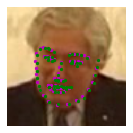

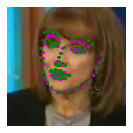

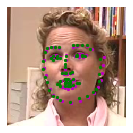

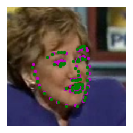

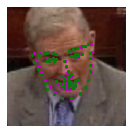

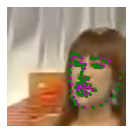

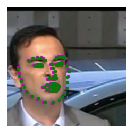

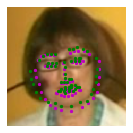

In [18]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(8):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, 8, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts.cpu())
        plt.axis('off')
        plt.savefig(f"{i}.png",bbox_inches = "tight", pad_inches = 0)
        

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [3]:
data = pd.read_csv("landmark_result_eff0_gray.csv")

In [4]:
data.head()

,0,1,2,3
0,0,1.043377,1.025406,0.001
1,1,1.017739,1.003470,0.001
2,2,1.013730,1.012731,0.001
3,3,1.012301,1.007173,0.001
4,4,1.017989,1.008828,0.001


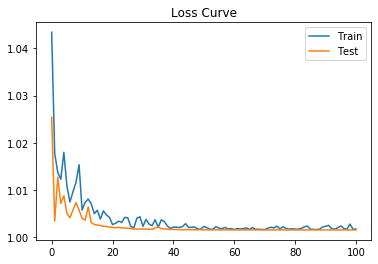

In [15]:
plt.plot(data[data["0"]<=100]["1"],label = "Train")
plt.plot(data[data["0"]<=100]["2"],label = "Test")
plt.legend()
plt.title("Loss Curve")
plt.savefig("loss curve.png")